In [243]:
import pandas as pd
import numpy as np 
from surprise import Dataset, Reader, accuracy
from surprise.prediction_algorithms import knns, matrix_factorization, slope_one, co_clustering
from surprise.model_selection import train_test_split, split, cross_validate, GridSearchCV

In [139]:
user_cols = ['user_id', 'location', 'age']
books_cols = ['isbn', 'book_title' ,'book_author','year_of_publication', 'publisher', 'img_s ', 'img_m', 'img_l']
ratings_cols = ['user_id', 'isbn', 'rating']

users = pd.read_csv('data/BX-Users.csv', sep=';', encoding='latin-1', names = user_cols, skiprows=1)
books = pd.read_csv('data/BX-Books.csv', sep=';', encoding='latin-1', names = books_cols, skiprows=1, on_bad_lines='skip')
ratings = pd.read_csv('data/BX-Book-Ratings.csv', sep=';', encoding='latin-1', names = ratings_cols, skiprows=1)

/Users/omar/opt/anaconda3/envs/AI_ML/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [141]:
# Filtering books with at least 5 ratings
book_ids, book_counts = np.unique(ratings.isbn, return_counts=True)
books_threshold = book_ids[[np.where(book_counts >= 5)[0]]]
new_ratings = ratings[ratings.isbn.isin(books_threshold)]

/var/folders/zp/h9zt3y1s3nb664kbw9s0vcp80000gn/T/ipykernel_31033/2447883892.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  books_threshold = book_ids[[np.where(book_counts >= 5)[0]]]


In [143]:
# Filtering users with at least 5 ratings
user_ids, user_counts = np.unique(new_ratings.user_id, return_counts=True)
users_threshold = user_ids[[np.where(user_counts >= 5)[0]]]
new_ratings = new_ratings[new_ratings.user_id.isin(users_threshold)]

/var/folders/zp/h9zt3y1s3nb664kbw9s0vcp80000gn/T/ipykernel_31033/675653206.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  users_threshold = user_ids[[np.where(user_counts >= 5)[0]]]


In [266]:
# Filtering books with at most 15 zero ratings
zero_ratings = new_ratings.iloc[np.where(new_ratings.rating == 0)[0], :]
zero_book_ids, zero_book_counts = np.unique(zero_ratings.isbn, return_counts=True)
new_book_ids = zero_book_ids[np.where(zero_book_counts <= 15)[0]]
new_rates = new_ratings[new_ratings.isbn.isin(new_book_ids)]

In [274]:
len(ratings), len(new_ratings), len(new_rates)

(1149780, 607651, 315145)

In [268]:
np.unique(new_rates.rating, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([208399,    376,    617,   1302,   2035,  11612,   8747,  18608,
         26081,  17557,  19811]))

In [269]:
# Transforming the data into surprise library format
reader = Reader(rating_scale=(0,10))
data = Dataset.load_from_df(new_rates, reader)
train, test = train_test_split(data, test_size=.3, random_state=42)

In [270]:
# Training SVD model
%%time
model = matrix_factorization.SVD()
model.fit(train)
predictions = model.test(test)

CPU times: user 16.1 s, sys: 161 ms, total: 16.2 s
Wall time: 16.3 s


In [279]:
result = pd.DataFrame(predictions, columns=['user_id', 'isbn', 'actual_rating', 'predicted_rating', 'details'])
result.drop(columns = ['details'], inplace = True)
result['error'] = abs(result['actual_rating'] - result['predicted_rating'])
result.head(10)

,user_id,isbn,actual_rating,predicted_rating,error
0,274612,0520055977,0.0,3.128353,3.128353
1,190925,0061013463,0.0,0.518666,0.518666
2,69389,0375501525,5.0,5.318280,0.318280
3,211426,0385314256,0.0,0.954207,0.954207
4,11676,044023462X,7.0,2.253519,4.746481
5,211426,0451517563,0.0,0.896196,0.896196
6,104636,0061076058,6.0,2.471887,3.528113
7,169663,0553803077,7.0,2.459393,4.540607
8,222391,0140177043,0.0,2.901437,2.901437
9,94951,0553258397,7.0,6.911105,0.088895


In [280]:
# Test accuracy
mse = accuracy.mse(predictions)
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

MSE: 11.6464
RMSE: 3.4127
MAE:  2.7417


In [273]:
# Cross Validation SVD model
%%time
kfold = split.KFold(n_splits=5, random_state=42)
cross_val = pd.DataFrame(cross_validate(model, data, cv=kfold, measures=['mse', 'rmse', 'mae']))
print(f'MSE: {np.mean(cross_val.test_mse)}\nRMSE: {np.mean(cross_val.test_rmse)}\nMAE: {np.mean(cross_val.test_mae)}')

MSE: 11.613279993570558
RMSE: 3.407804137344486
MAE: 2.7305219080447265
CPU times: user 1min 33s, sys: 518 ms, total: 1min 34s
Wall time: 1min 34s


In [278]:
cross_val.sort_values(['test_mae'])

,test_mse,test_rmse,test_mae,fit_time,test_time
2,11.536406,3.396529,2.720484,17.419217,0.585211
4,11.588397,3.404173,2.724664,17.394250,0.551467
1,11.559530,3.399931,2.724938,16.828343,0.564935
0,11.608262,3.407090,2.732673,17.071027,0.584009
3,11.773805,3.431298,2.749851,17.227872,0.555096


<AxesSubplot:>

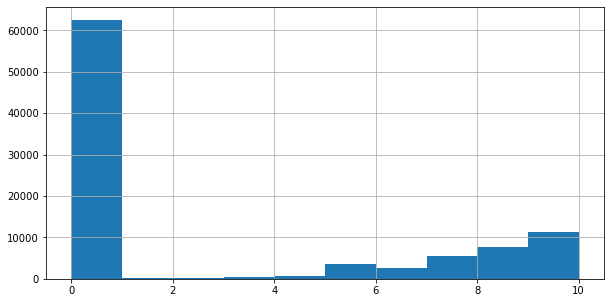

In [275]:
result['actual_rating'].hist(bins=10, figsize=(10,5))

<AxesSubplot:>

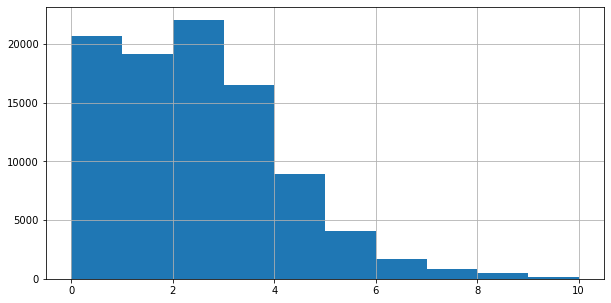

In [276]:
result['predicted_rating'].hist(bins=10, figsize=(10,5))